In [1]:
from fastai.collab import *
from fastai.tabular.all import *
from time import *

In [2]:
path = Path('.')
df = pd.read_csv(path/'training_data_v2.csv', delimiter=',', engine='python',
                     header=0)

In [3]:
df.head()

,date,morning_temp,morning_wind,morning_humidity,morning_rain,morning_cloud,noon_temp,noon_wind,noon_humidity,noon_rain,noon_cloud,afternoon_temp,afternoon_wind,afternoon_humidity,afternoon_rain,afternoon_cloud,daily_power
0,2012-01-01,11.846154,19.384615,90.769231,no rain,overcast clouds,12.900000,19.000000,88.600000,no rain,overcast clouds,13.076923,27.000000,87.538462,rain,overcast clouds,5.6
1,2012-01-02,8.071429,15.214286,84.285714,no rain,broken clouds,8.555556,19.333333,79.333333,no rain,broken clouds,6.071429,17.285714,76.214286,no rain,clear sky,2.5
2,2012-01-03,6.857143,32.500000,80.428571,no rain,broken clouds,10.700000,43.100000,82.200000,rain,few clouds,9.642857,32.071429,74.071429,no rain,broken clouds,7.6
3,2012-01-04,7.000000,28.714286,67.785714,no rain,broken clouds,7.700000,25.200000,67.500000,no rain,broken clouds,7.785714,26.142857,76.357143,no rain,broken clouds,15.1
4,2012-01-05,9.384615,40.230769,81.461538,rain,broken clouds,8.777778,41.111111,69.888889,no rain,broken clouds,6.444444,38.333333,73.777778,no rain,broken clouds,13.1


In [4]:
df['noon_cloud'].unique()

array(['overcast clouds', 'broken clouds', 'few clouds',
       'scattered clouds', 'clear sky'], dtype=object)

/home/nhat/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


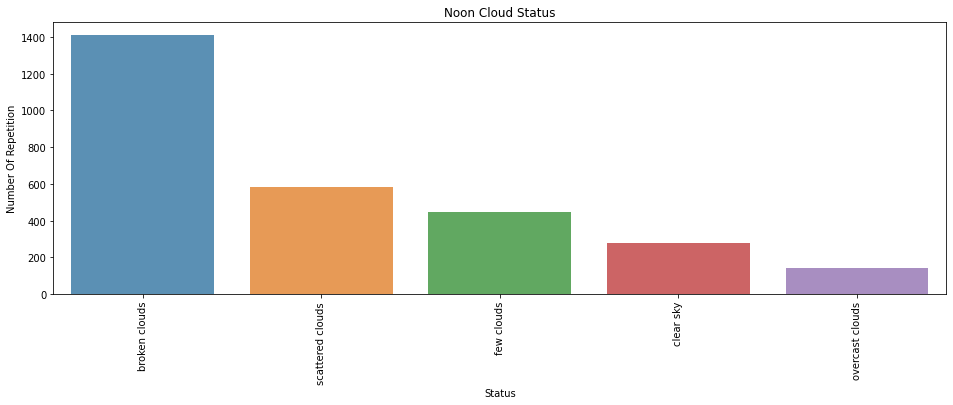

In [5]:
import seaborn as sns
weather_counts = df['noon_cloud'].value_counts()
plt.figure(figsize=(16,5))
sns.barplot(weather_counts.index, weather_counts.values, alpha=0.8)
plt.xticks(rotation=90)
plt.title('Noon Cloud Status')
plt.xlabel('Status')
plt.ylabel('Number Of Repetition')
plt.show()

In [6]:
df['noon_rain'].unique()

array(['no rain', 'rain', 'snow', 'drizzle'], dtype=object)

'rain' can be seen as pure caregorical data since they cannot be put into a suitable ordering. However, 'cloud' in this case is ordinal columns. According to the document of OpenWeather API, the order is as follow:

In [7]:
cloud_levels = 'overcast clouds', 'broken clouds', 'scattered clouds', 'few clouds', 'clear sky'
#cloud_levels = 'Overcast', 'Cloudy', 'Mostly cloudy', 'Haze', 'Ice Fog', 'Fog', 'Broken clouds', 'More clouds than sun', 'Passing clouds', 'Scattered clouds', 'Low clouds', 'Partly sunny', 'Clear', 'Sunny'

In [8]:
df.isna().sum()

date                  0
morning_temp          0
morning_wind          0
morning_humidity      0
morning_rain          0
morning_cloud         0
noon_temp             0
noon_wind             0
noon_humidity         0
noon_rain             0
noon_cloud            0
afternoon_temp        0
afternoon_wind        0
afternoon_humidity    0
afternoon_rain        0
afternoon_cloud       0
daily_power           0
dtype: int64

In [9]:
df['morning_cloud'] = df['morning_cloud'].astype('category')
df['noon_cloud'] = df['noon_cloud'].astype('category')
df['afternoon_cloud'] = df['afternoon_cloud'].astype('category')
df['morning_cloud'].cat.set_categories(cloud_levels, ordered=True, inplace=True)
df['noon_cloud'].cat.set_categories(cloud_levels, ordered=True, inplace=True)
df['afternoon_cloud'].cat.set_categories(cloud_levels, ordered=True, inplace=True)

Date is useless in predicting the energy production, so we can drop it out

In [10]:
df.drop(labels='date', axis=1, inplace=True)
df.head()

,morning_temp,morning_wind,morning_humidity,morning_rain,morning_cloud,noon_temp,noon_wind,noon_humidity,noon_rain,noon_cloud,afternoon_temp,afternoon_wind,afternoon_humidity,afternoon_rain,afternoon_cloud,daily_power
0,11.846154,19.384615,90.769231,no rain,overcast clouds,12.900000,19.000000,88.600000,no rain,overcast clouds,13.076923,27.000000,87.538462,rain,overcast clouds,5.6
1,8.071429,15.214286,84.285714,no rain,broken clouds,8.555556,19.333333,79.333333,no rain,broken clouds,6.071429,17.285714,76.214286,no rain,clear sky,2.5
2,6.857143,32.500000,80.428571,no rain,broken clouds,10.700000,43.100000,82.200000,rain,few clouds,9.642857,32.071429,74.071429,no rain,broken clouds,7.6
3,7.000000,28.714286,67.785714,no rain,broken clouds,7.700000,25.200000,67.500000,no rain,broken clouds,7.785714,26.142857,76.357143,no rain,broken clouds,15.1
4,9.384615,40.230769,81.461538,rain,broken clouds,8.777778,41.111111,69.888889,no rain,broken clouds,6.444444,38.333333,73.777778,no rain,broken clouds,13.1


fastai determines which columns should be treated as categorical variables by comparing the number of distinct levels in the variable to the value of the max_card variable:

In [11]:
#df.drop(labels=['cloud', 'rain'], axis=1, inplace=True)
cont_df,cat_df = cont_cat_split(df, max_card = 15, dep_var = 'daily_power')

In [12]:
df[cat_df].nunique()

morning_rain       4
morning_cloud      5
noon_rain          4
noon_cloud         5
afternoon_rain     5
afternoon_cloud    5
dtype: int64

The data must be normalized before being fed to the neural network:

In [27]:
procs_nn = [Categorify, Normalize]
splits = RandomSplitter(0.3)(range_of(df))
to_nn = TabularPandas(df, procs_nn, cat_df, cont_df, splits=splits, y_names='daily_power')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2862 entries, 0 to 2861
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   morning_temp        2862 non-null   float64 
 1   morning_wind        2862 non-null   float64 
 2   morning_humidity    2862 non-null   float64 
 3   morning_rain        2862 non-null   object  
 4   morning_cloud       2862 non-null   category
 5   noon_temp           2862 non-null   float64 
 6   noon_wind           2862 non-null   float64 
 7   noon_humidity       2862 non-null   float64 
 8   noon_rain           2862 non-null   object  
 9   noon_cloud          2862 non-null   category
 10  afternoon_temp      2862 non-null   float64 
 11  afternoon_wind      2862 non-null   float64 
 12  afternoon_humidity  2862 non-null   float64 
 13  afternoon_rain      2862 non-null   object  
 14  afternoon_cloud     2862 non-null   category
 15  daily_power         2862 non-null   fl

In [29]:
dls = to_nn.dataloaders(500)

In [30]:
y = to_nn.train.y
y.min(), y.max()

(0.04, 34.0)

In [31]:
from fastai.tabular.all import*

In [35]:
learn = tabular_learner(dls, layers=[1000,500], y_range=(-0.2, 34.5), n_out=1, loss_func=F.mse_loss)

SuggestedLRs(lr_min=0.002754228748381138, lr_steep=0.00015848931798245758)

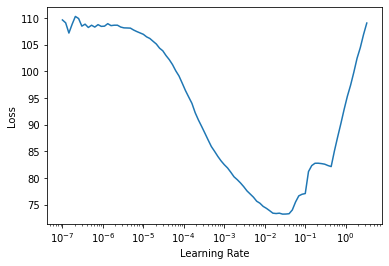

In [36]:
learn.lr_find()

In [37]:
learn.fine_tune(15, 2e-2)

epoch,train_loss,valid_loss,time
0,96.508293,61.702709,00:00


epoch,train_loss,valid_loss,time
0,103.620461,54.038971,00:00
1,83.384926,57.551834,00:00
2,74.966240,49.802902,00:00
3,72.447472,55.386700,00:00
4,69.198868,61.316006,00:00
5,66.814278,46.846321,00:00
6,64.197151,50.986614,00:00
7,61.944702,48.632633,00:00
8,60.028549,47.441608,00:00
9,58.260010,47.359367,00:00


In [38]:
preds,targs = learn.get_preds()

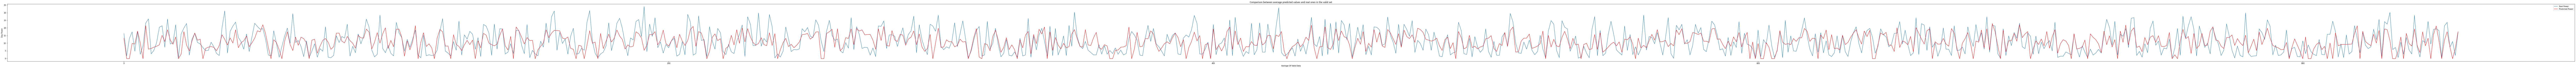

In [39]:
plt.figure(figsize=(260,6))
plt.plot(range(len(targs)), targs)
plt.plot(range(len(preds)), preds, 'r')
plt.title('Comparison between average predicted values and real ones in the valid set')
plt.ylabel('Day Power')
plt.xlabel('Average Of Valid Data')
plt.legend(['Real Power', 'Predicted Power'])
plt.show()